# Librerias y datos

In [1]:
# Librerias necesarias
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Cargar los datos
df = pd.read_excel("../data/0 TimeLog (original, no modificar).xlsx")

In [3]:
# Copio para no modificar el original
tl = df.copy()

In [4]:
# Agrego LOS a cada fila
tl["LOS"] = (tl["TF"] - tl["TI"])

# Ajuste a Log_Normal

LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=1, Chi² = 105.94, valor-p = 0.0000
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=2, Chi² = 193.58, valor-p = 0.0000
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=3, Chi² = 21.84, valor-p = 0.2393
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=4, Chi² = 86.99, valor-p = 0.0000
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=5, Chi² = 57.95, valor-p = 0.0000
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=6, Chi² = 13.15, valor-p = 0.3580
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=7, Chi² = 108.31, valor-p = 0.0000
LOS Histograma vs Ajuste Log-normal, Unidad=ICU, Hospital=3, GRD=8, Chi² = 49.75, valor-p = 0.0006


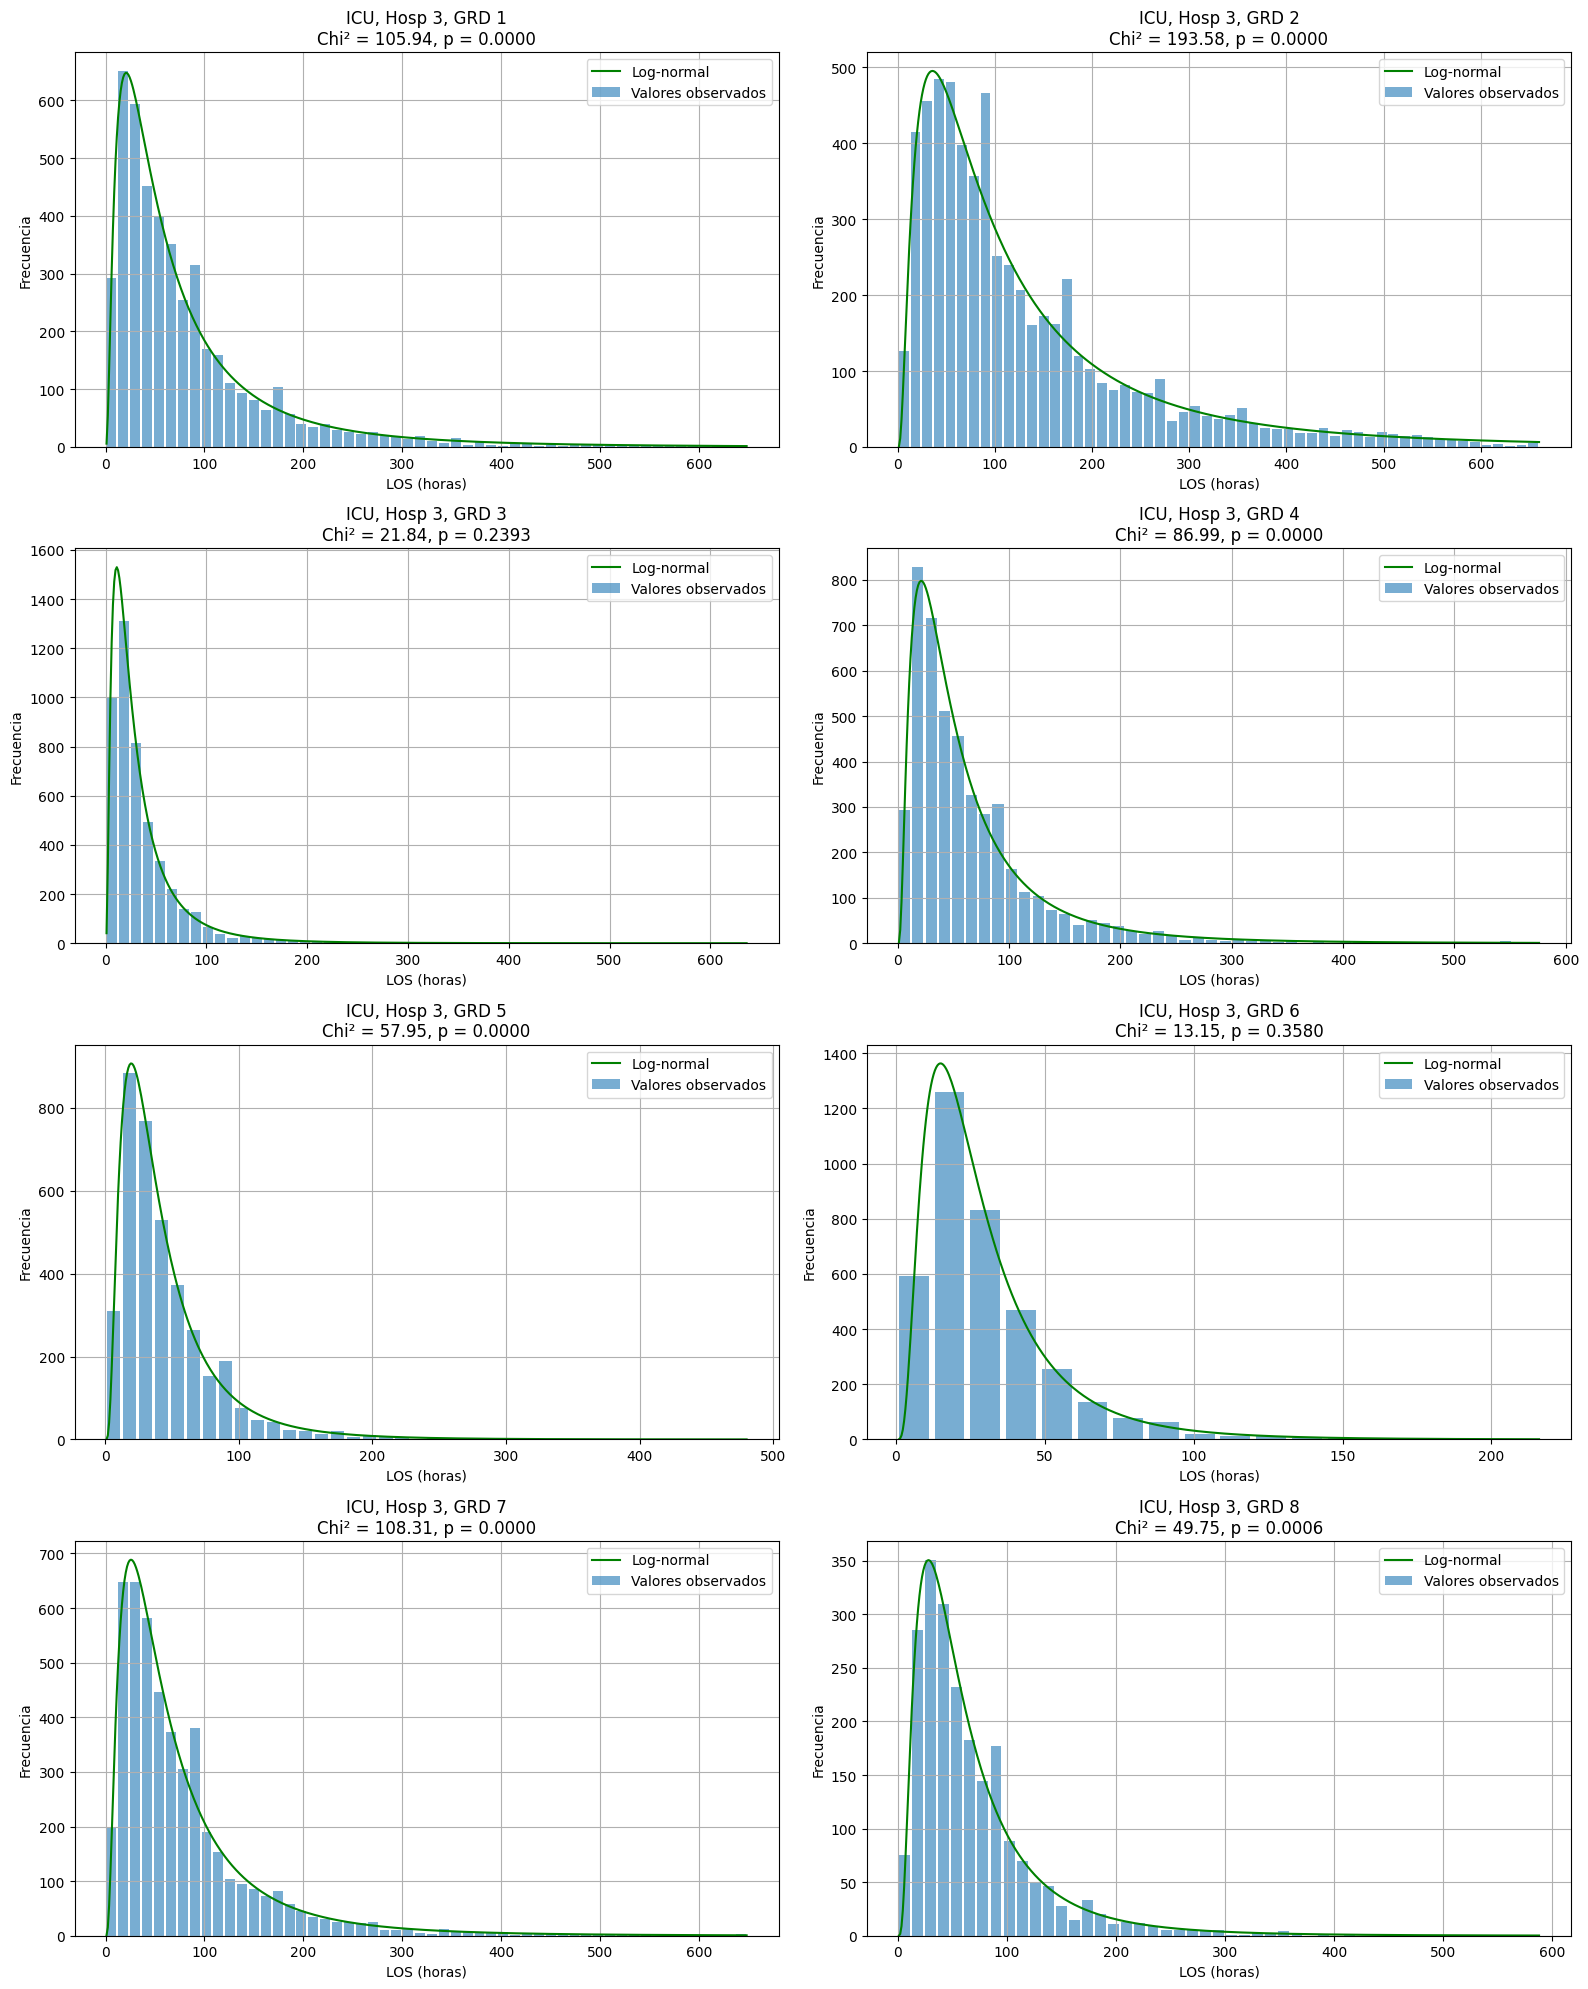

In [31]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axs = axs.flatten()  # para indexar fácilmente como lista
plot_idx = 0  # índice del subplot
for i in range(3,4):
    for grd in range(1,9):
        for unidad in ["ICU"]:
            # ---- 1. Filter your dataset
            tl_u = tl[tl["UNIDAD"].isin(["ICU", "OR", "SDU_WARD"])]
            v1 = tl_u[(tl_u["UNIDAD"] == unidad) & (tl_u["MS_GRD"] == grd) & (tl_u["HOSPITAL"] == f"Hospital_{i}")]
            # v1 = tl_u[(tl_u["UNIDAD"] == unidad) & (tl_u["MS_GRD"] == grd)]

            # ---- 2. Get LOS value counts
            vector = v1["LOS"].value_counts().reset_index().sort_values(by="LOS")
            vector.columns = ["LOS", "count"]

            # ---- 3. Build raw data from LOS values and their frequencies
            los = np.array(vector["LOS"])
            ocurrencias = np.array(vector["count"])
            raw_data = np.repeat(los, ocurrencias)

            # ---- 4. Definir los bins de 12 horas
            bin_width = 12
            max_los = np.max(raw_data)
            edges = np.arange(0, max_los + bin_width, bin_width)
            midpoints = (edges[:-1] + edges[1:]) / 2  # midpoint of (a, b] is (a + b) / 2
    

            # ---- 5. Meter datos a bins individuales (0 - 12], (12 - 24], ...)
            # agrega 0 si no hay datos para ese bin
            bin_indices = np.digitize(raw_data, edges, right=True)
            hist = np.array([(bin_indices == i).sum() for i in range(1, len(edges))])

#--------------------------------Hasta aca esta bien----------------------------------------

            # ---- 6. Ajustar log normal a datos usando metodo "MLE"
            shape, loc, scale = stats.lognorm.fit(raw_data, floc=0)

            # ---- Optimización
            def chi2_objective(params, hist, edges, total_count):
                shape, loc, scale = params
                # Ensure parameters are valid
                if shape <= 0 or scale <= 0:
                    return np.inf
                cdf_low = stats.lognorm.cdf(edges[:-1], shape, loc, scale)
                cdf_high = stats.lognorm.cdf(edges[1:], shape, loc, scale)
                expected_probs = cdf_high - cdf_low
                expected_counts = expected_probs * total_count

                # Mask for bins with enough expected values
                mask = expected_counts >= 5
                if not np.any(mask):
                    return np.inf
                obs = hist[mask]
                exp = expected_counts[mask]
                
                # Normalize expected to match sum of obs
                exp *= obs.sum() / exp.sum()
                chi2 = np.sum((obs - exp)**2 / exp)
                return chi2
            
            initial_shape, initial_loc, initial_scale = stats.lognorm.fit(raw_data, floc=0)
            # Minimize the chi-square
            result = minimize(
                chi2_objective,
                x0=[initial_shape, initial_loc, initial_scale],
                args=(hist, edges, len(raw_data)),
                bounds=[(1e-5, None), (0, None), (1e-5, None)],
                method='L-BFGS-B'
            )
            # Extract optimized parameters
            opt_shape, opt_loc, opt_scale = result.x
            shape = opt_shape
            loc = opt_loc
            scale = opt_scale


            # ---- 7. Compute expected counts per bin using log-normal CDF
            cdf_low = stats.lognorm.cdf(edges[:-1], shape, loc, scale)
            cdf_high = stats.lognorm.cdf(edges[1:], shape, loc, scale)
            expected_probs = cdf_high - cdf_low
            expected_counts = expected_probs * len(raw_data)

            # ---- 9. Chi-square test (only where expected counts ≥ 5)
            mask = expected_counts >= 5
            obs = hist[mask]
            exp = expected_counts[mask]

            # Normalize expected counts to match the total of observed
            if exp.sum() > 0:
                exp *= obs.sum() / exp.sum()

            # Chi-square test
            if np.any(mask):
                chi2, p = stats.chisquare(f_obs=obs, f_exp=exp)

            print(f'LOS Histograma vs Ajuste Log-normal, Unidad={unidad}, Hospital={i}, GRD={grd}, Chi² = {chi2:.2f}, valor-p = {p:.4f}')
            # ---- 8. Plot observed vs. expected
            ax = axs[plot_idx]
            plot_idx += 1  # avanzar al siguiente subplot

            ax.bar(midpoints, hist, width=bin_width - 2, alpha=0.6, label='Valores observados')
            ax.set_xlabel('LOS (horas)')
            ax.set_ylabel('Frecuencia')
            ax.set_title(f'{unidad}, Hosp {i}, GRD {grd}\nChi² = {chi2:.2f}, p = {p:.4f}')
            ax.grid(True)

            # Curva log-normal ajustada
            x_vals = np.linspace(1, max_los, 500)
            pdf_vals = stats.lognorm.pdf(x_vals, s=shape, loc=loc, scale=scale)
            pdf_scaled = pdf_vals * len(raw_data) * bin_width
            ax.plot(x_vals, pdf_scaled, 'g-', label='Log-normal')

            # Opcional: línea vertical para el corte de cola
            # ax.axvline(umbral_corte, color='gray', linestyle='--', label='Corte percentil')

            ax.legend()

plt.tight_layout()
plt.show()
